In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from pickle import dump,load
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
data=pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
def preprocessing_text(text):
    pattern=r'[^A-Za-z0-9\s]'
    text=re.sub(pattern,'',text)
    text=text.split()
    text=[word.lower() for word in text]
    text=[word for word in text if word.isalpha()]
    text=' '.join(text)
    text= 'sos '+ text + ' eos'
    return text

In [6]:
data['caption']=data['caption'].apply(preprocessing_text)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,sos a child in a pink dress is climbing up a s...
1,1000268201_693b08cb0e.jpg,sos a girl going into a wooden building eos
2,1000268201_693b08cb0e.jpg,sos a little girl climbing into a wooden playh...
3,1000268201_693b08cb0e.jpg,sos a little girl climbing the stairs to her p...
4,1000268201_693b08cb0e.jpg,sos a little girl in a pink dress going into a...


In [7]:
word_counts={}
max_length=0
for caption in data['caption']:
    words=caption.split()
    max_length=max(max_length,len(words))
    for word in words:
        if word in word_counts:
            word_counts[word]+=1
        else:
            word_counts[word]=1
print(len(word_counts))
print(max_length)

8777
37


In [8]:
threshold=10
vocab=[word for word,freq in word_counts.items() if freq>=threshold]
len(vocab)

1952

In [9]:
word_to_index={}
index_to_word={}
i=1
for word in vocab:
    word_to_index[word]=i
    index_to_word[i]=word
    i+=1

In [ ]:
vocab_size=len(vocab)+1
embedding_dim=200
embedding_matrix=np.zeros((vocab_size,embedding_dim))
for word,index in word_to_index.items():
    embedding_vector=embeddings_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector
print(embedding_matrix.shape)

In [ ]:
vocab_size=len(vocab)+1

In [ ]:
with open('/kaggle/working/embedding_matrix.pkl','wb') as file:
    dump(embedding_matrix,file)

In [ ]:
embedding_matrix=load(open('/kaggle/input/embedding-matrix/embedding_matrix.pkl','rb'))
embedding_matrix.shape

In [ ]:
images={}
captions={}
for i in range(len(data)):
    img=data['image'][i]
    if img not in images:
        img_path=os.path.join(path,img)
        tmp=cv2.imread(img_path)
        tmp=cv2.cvtColor(tmp,cv2.COLOR_BGR2RGB)
        images[img]=np.array(tmp)
    try:
        captions[data['image'][i]].append(data['caption'][i])
    except:
        captions[data['image'][i]]=[data['caption'][i]]

In [ ]:
with open('/kaggle/working/images.pkl','wb') as file:
    dump(images,file)

In [ ]:
with open('/kaggle/working/captions.pkl','wb') as file:
    dump(captions,file)

In [ ]:
model=InceptionV3()

In [ ]:
model_new=Model(model.input,model.layers[-2].output)

In [ ]:
def encode(image):
    image=np.resize(image,(299,299,3))
    image=np.expand_dims(image,axis=0)
    image=preprocess_input(image)
    
    extracted_feat=model_new.predict(image)
    extracted_feat=np.squeeze(extracted_feat,axis=0)
    return extracted_feat

In [ ]:
encoding_image={}
for name,image in images.items():
    encoding_image[name]=encode(image)


In [ ]:
with open('/kaggle/working/feature_vector.pkl','wb') as file:
    dump(encoding_image,file)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
def data_generator(captions,images,word_to_index,max_length,batch_size,vocab_size):
    X_image,X_cap,y=[],[],[]
    n=0
    while 1:
        for image_path,caption in captions.items():
            n+=1
            image=images[image_path]
            for cap in caption:
                seq=[word_to_index[word] for word in cap.split(' ') if word in word_to_index]
                for i in range (1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]

                    in_seq=pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    X_image.append(image)
                    X_cap.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                yield ((np.array(X_image),np.array(X_cap)),np.array(y))
                X_image,X_cap,y=[],[],[]
                n=0
            

In [11]:
vocab_size=len(vocab)+1
embedding_dim=200
max_length=37

In [12]:
embedding_matrix=load(open('/kaggle/input/embedding-matrix/embedding_matrix.pkl','rb'))
captions=load(open('/kaggle/input/needed/captions.pkl','rb'))
encoding_image=load(open('/kaggle/input/needed/feature_vector.pkl','rb'))

In [68]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)


inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256,use_cudnn=False)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 16
steps = len(encoding_image)

In [22]:
checkpoint_path = "/kaggle/working/Image Captioning/image_caption.weights.h5"

from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [23]:
generator = data_generator(captions=captions, images=encoding_image, word_to_index=word_to_index, max_length=max_length, batch_size=batch_size,vocab_size=vocab_size)

In [ ]:
model.fit(generator, epochs=epochs,steps_per_epoch=steps, verbose=1, callbacks=[cp_callback])

In [65]:
def beamSearch(photo, beam=3):
    in_text = [['sos', 0]]
    
    for i in range(max_length):
        all_candidates = []
        for seq, score in in_text:
            sequences = [word_to_index[w] for w in seq.split() if w in word_to_index]
            sequences = pad_sequences([sequences], maxlen=max_length)
            yhat = model.predict([photo, sequences], verbose=0)
            
            top_seq = np.argsort(yhat[0])[-beam:]
            for index in top_seq:
                word = index_to_word[index]
                new_seq = seq + ' ' + word
                new_score = score + np.log(yhat[0][index])
                all_candidates.append([new_seq, new_score])
        in_text = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam]
    pred = in_text[0][0]
    final_caption = []
    for word in pred.split():
        if word == 'eos':  
            break
        if word != 'sos':
            final_caption.append(word)
    return ' '.join(final_caption)


In [45]:
def greedySearch(photo):
    in_text = 'sos'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'eos':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

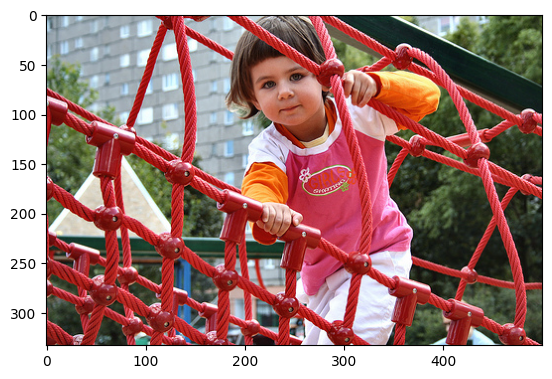

a little boy in a white shirt is pointing at the camera


In [69]:
image_path='/kaggle/input/flickr8k/Images/'
z=5
pic = list(encoding_image.keys())[z]
image = encoding_image[pic].reshape((1,2048))
x=plt.imread(image_path+pic)
plt.imshow(x)
plt.show()
print(beamSearch(image))